In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

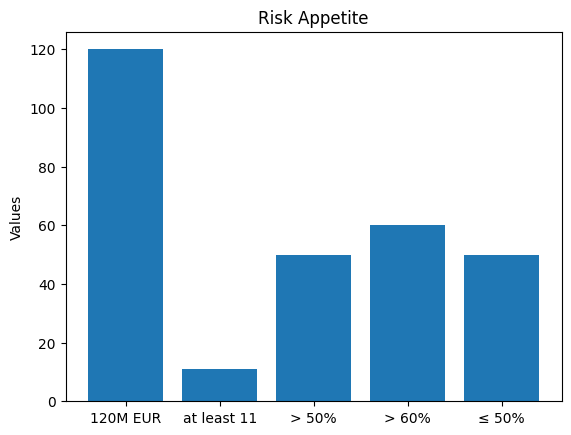

In [2]:
import matplotlib.pyplot as plt

risk_appetite = ['120M EUR', 'at least 11', '> 50%', '> 60%', '≤ 50%', '≤ 50%']
values = [120, 11, 50, 60, 50, 50]

plt.bar(risk_appetite, values)
plt.title('Risk Appetite')
plt.ylabel('Values')
plt.show()


In [ ]:
df = pd.read_csv("../input/credit-risk-dataset/credit_risk_dataset.csv")

In [ ]:
df

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
#EDA
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(250, 15, as_cmap=True, center = "dark"),
            square=True, ax=ax)

In [ ]:
plt.figure(figsize=(9,9))
sns.countplot(x=df["loan_status"])

In [ ]:
plt.figure(figsize=(9,9))
sns.countplot(x=df["loan_status"], hue=df["loan_intent"])

In [ ]:
numerical_cols1 = [numname for numname in df.columns if df[numname].dtype in ['int64', 'float64']]
numerical_cols1.remove("loan_status")

In [ ]:
plt.figure(figsize = (25, 25))
for i in enumerate(numerical_cols1):
    plt.subplot(3, 3,i[0]+1)
    #sns.countplot(i[1],data = df)
    sns.distplot(df, x = df[i[1]])
    plt.title(i[1])
    

In [ ]:
#Splitting Dataset
x = df.drop("loan_status", axis=1)
y = df.loan_status
X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


In [ ]:
X_train.isnull().sum()
x_test.isnull().sum()

In [ ]:
for colname in x.select_dtypes("object"):
    x[colname], _ = x[colname].factorize()
discrete_features = x.dtypes == int

def make_mi_scores(x, y, discrete_features):
    mi_scores = mutual_info_regression(x, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)

In [ ]:
#preprocessing
numerical_transformer = SimpleImputer(strategy='constant')

categorical_cols = [catname for catname in X_train.columns if X_train[catname].nunique() < 10 and 
                        X_train[catname].dtype == "object"]

# Select numerical columns

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols1),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [ ]:
#feature selection
from sklearn.feature_selection import SelectPercentile, chi2
selection = SelectPercentile(chi2, percentile= 80)

In [ ]:
#model
model  = XGBClassifier(learning_rate = 0.05)

In [ ]:
#pipeline

mypipeline = Pipeline(steps = [("preprocessor", preprocessor),
                               ("selection", selection),
                               ('model', model)
                              ])

In [ ]:
#crossvalidation and scoring
scores = cross_val_score(mypipeline, X_train, y_train,
                              cv=5,
                              scoring="accuracy")

print("MAE score:\n", scores.mean())

In [ ]:
#Hyperoptimization
param_grid = {
    "model__learning_rate": np.arange(0.01,0.3,0.08),
    "model__max_depth":np.arange(1,10,1)
}

hyper = GridSearchCV(
    estimator = mypipeline,
    param_grid = param_grid ,
    scoring = "accuracy",
    verbose = 10,
    cv = 5)

hyper.fit(X_train,y_train)

In [ ]:
print(hyper.best_score_)
print(hyper.best_estimator_)

In [ ]:
predict = hyper.best_estimator_.predict(x_test)
test_score = accuracy_score(predict,y_test)
test_score*100